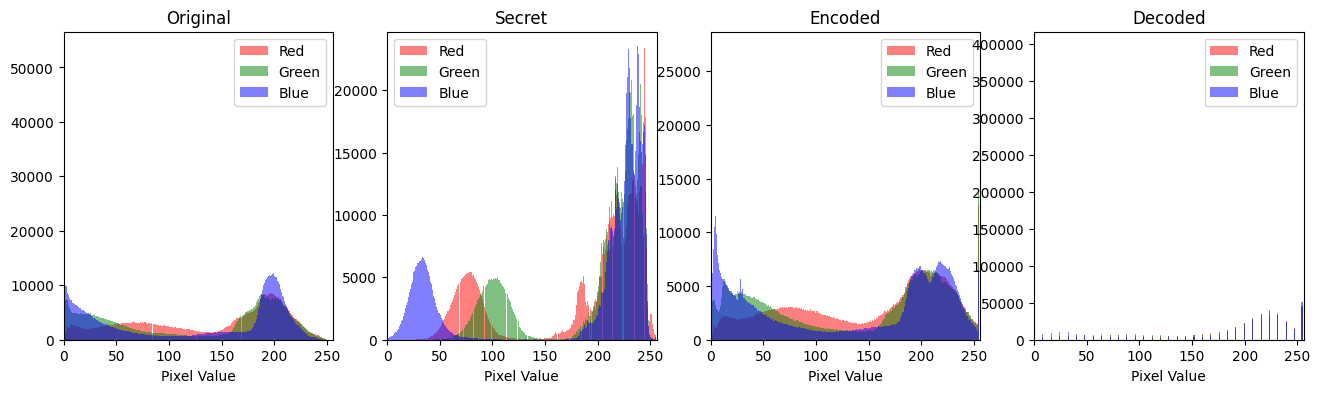

PSNR value:  23.405379242646895


In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def plot_histograms(image_paths, titles):
    num_images = len(image_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(16, 4))

    for idx, (image_path, title) in enumerate(zip(image_paths, titles)):
        image = Image.open(image_path).convert('RGB')
        image_pixels = image.getdata()

        r_channel = [pixel[0] for pixel in image_pixels]
        g_channel = [pixel[1] for pixel in image_pixels]
        b_channel = [pixel[2] for pixel in image_pixels]

        axes[idx].hist(r_channel, bins=256, color='red', alpha=0.5, label='Red')
        axes[idx].hist(g_channel, bins=256, color='green', alpha=0.5, label='Green')
        axes[idx].hist(b_channel, bins=256, color='blue', alpha=0.5, label='Blue')
        axes[idx].set_title(title)
        axes[idx].set_xlabel('Pixel Value')
        axes[idx].set_xlim([0, 256])
        axes[idx].legend()

    plt.show()

def pvd_encode_channel(cover_channel_pixels, secret_channel_pixels, width, height):
    for i in range(0, width, 2):
        for j in range(height):
            cover_pair = cover_channel_pixels[i, j], cover_channel_pixels[i + 1, j]
            difference = abs(cover_pair[0] - cover_pair[1])
            secret_pixel = secret_channel_pixels[i, j] // 8

            if difference < secret_pixel:
                new_pair = (cover_pair[0] + secret_pixel, cover_pair[1])
            else:
                new_pair = (cover_pair[0], cover_pair[1] + secret_pixel)

            cover_channel_pixels[i, j] = new_pair[0]
            cover_channel_pixels[i + 1, j] = new_pair[1]

def pvd_decode_channel(encoded_channel_pixels, width, height):
    decoded_channel = Image.new('L', (width, height))
    decoded_pixels = decoded_channel.load()

    for i in range(0, width, 2):
        for j in range(height):
            encoded_pair = encoded_channel_pixels[i, j], encoded_channel_pixels[i + 1, j]
            secret_pixel = abs(encoded_pair[0] - encoded_pair[1]) * 8
            decoded_pixels[i, j] = secret_pixel

    return decoded_channel

def pvd_encode_rgb(cover_image_path, secret_image_path, output_image_path):
    cover_image = Image.open(cover_image_path).convert('RGB')
    secret_image = Image.open(secret_image_path).convert('RGB')

    width, height = cover_image.size

    cover_channels = cover_image.split()
    secret_channels = secret_image.split()

    for cover_channel, secret_channel in zip(cover_channels, secret_channels):
        pvd_encode_channel(cover_channel.load(), secret_channel.load(), width, height)

    encoded_image = Image.merge('RGB', cover_channels)
    encoded_image.save(output_image_path)

def pvd_decode_rgb(encoded_image_path, output_image_path):
    encoded_image = Image.open(encoded_image_path).convert('RGB')
    width, height = encoded_image.size
    encoded_channels = encoded_image.split()

    decoded_channels = [pvd_decode_channel(channel.load(), width, height) for channel in encoded_channels]

    decoded_image = Image.merge('RGB', decoded_channels)
    decoded_image.save(output_image_path)

def mse(image1, image2):
    image1_array = np.array(image1, dtype=np.float64)
    image2_array = np.array(image2, dtype=np.float64)
    error = np.square(image1_array - image2_array)
    return np.mean(error)

def psnr(image1, image2, max_pixel_value=255):
    mean_square_error = mse(image1, image2)

    if mean_square_error == 0:
        return float('inf')

    return 20 * np.log10(max_pixel_value) - 10 * np.log10(mean_square_error)


cover_image_path = 'filtered_1/00000321.jpg'
secret_image_path = 'filtered_1/00000300.jpg'
encoded_image_path = 'encoded_image.png'
decoded_image_path = 'decoded_image.png'

pvd_encode_rgb(cover_image_path, secret_image_path, encoded_image_path)
pvd_decode_rgb(encoded_image_path, decoded_image_path)

cover_image = Image.open(cover_image_path).convert('RGB')
encoded_image = Image.open(encoded_image_path).convert('RGB')

image_paths = [cover_image_path, secret_image_path, encoded_image_path, decoded_image_path]
titles = ['Original', 'Secret', 'Encoded', 'Decoded']
plot_histograms(image_paths, titles)

psnr_value = psnr(cover_image, encoded_image)
print('PSNR value: ', psnr_value)